In [1]:
from osgeo import gdal, ogr, osr
import geopandas as gpd
import matplotlib.pyplot as plt

## Information about download dem

When working with geospatial data in raster format it's crucial to understand in what projection is the data and the value of the data for the pixels with 'no data'.

In [5]:
input_file = "../source_data/dem.tif"
# open dem with gdal
dem = gdal.Open(input_file)
band = dem.GetRasterBand(1) # this rawster only has one band
array = band.ReadAsArray()

print(dem.GetProjection())

PROJCS["NAD83(2011) / Florida North (ftUS)",GEOGCS["NAD83(2011)",DATUM["NAD83_National_Spatial_Reference_System_2011",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1116"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6318"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",29],PARAMETER["central_meridian",-84.5],PARAMETER["standard_parallel_1",30.75],PARAMETER["standard_parallel_2",29.5833333333333],PARAMETER["false_easting",1968500],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6441"]]


In [6]:
# raster values as array
array

array([[-999999., -999999., -999999., ..., -999999., -999999., -999999.],
       [-999999., -999999., -999999., ..., -999999., -999999., -999999.],
       [-999999., -999999., -999999., ..., -999999., -999999., -999999.],
       ...,
       [-999999., -999999., -999999., ..., -999999., -999999., -999999.],
       [-999999., -999999., -999999., ..., -999999., -999999., -999999.],
       [-999999., -999999., -999999., ..., -999999., -999999., -999999.]],
      dtype=float32)

In [9]:
# values of no data 
band.GetNoDataValue()

-999999.0

In [8]:
array.shape

(2891, 10692)

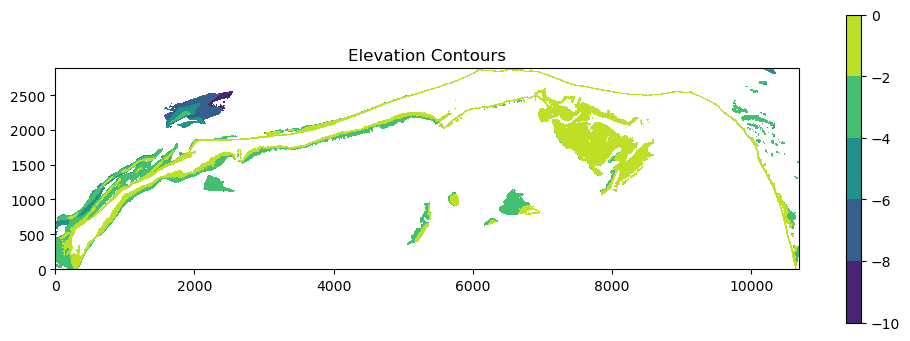

In [19]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(array, cmap = "viridis", 
            levels = list(range(-10, 2, 2)))
plt.title("Elevation Contours")
cbar = plt.colorbar(shrink=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Reproject to EPSG:4326 (WGS84)

In [20]:
output_file = "../source_data/dem_rep.tif"

# define the target CRS 
target_crs = "EPSG:4326"

# GDAL WarpOptions to reproject 
warp_options = gdal.WarpOptions(dstSRS=target_crs)

# reproject 
gdal.Warp(output_file, dem, options=warp_options)

dem = None

## Create the shapefile

In [22]:
dem_r_path =  "../source_data/dem_rep.tif"

In [23]:
dem_rep = gdal.Open(dem_r_path)
print(dem_rep.GetProjection())

band = dem_rep.GetRasterBand(1)
array = band.ReadAsArray()

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [24]:
output_shp = '../source_data/shp/out_shapefile.shp'

# assign projection to the new shp
proj = dem_rep.GetProjection()
shp_proj = osr.SpatialReference()
shp_proj.ImportFromWkt(proj)

# gets ogr driver
call_drive = ogr.GetDriverByName('ESRI Shapefile')
# create new shp using the driver
create_shp = call_drive.CreateDataSource(output_shp) 
print(create_shp)

<osgeo.ogr.DataSource; proxy of <Swig Object of type 'OGRDataSourceShadow *' at 0x000001AADCCA5E30> >


In [25]:
shp_layer = create_shp.CreateLayer('depths_layer', srs=shp_proj)

# add a new field to store depth as string
new_field = ogr.FieldDefn('depth', ogr.OFTString)  # Integer field for raster values
shp_layer.CreateField(new_field)

# create a memory layer to temporarily hold polygonized values
mem_driver = ogr.GetDriverByName('Memory')
mem_ds = mem_driver.CreateDataSource("temp_memory")
mem_layer = mem_ds.CreateLayer('temp_layer', srs=shp_proj)
mem_field = ogr.FieldDefn('RasterVal', ogr.OFTInteger)
mem_layer.CreateField(mem_field)

gdal.Polygonize(band, None, mem_layer, 0, [], callback=None)

0

In [27]:
for feature in mem_layer:
    raster_value = feature.GetField('RasterVal')
    geometry = feature.GetGeometryRef()
    
    if 0 >= raster_value >= -0.5: 
        # create a new feature for the shapefile
        new_feature = ogr.Feature(shp_layer.GetLayerDefn())
        new_feature.SetField('depth', '0 to -0.5')  # filtered value
        new_feature.SetGeometry(geometry)  # copy geometry
        shp_layer.CreateFeature(new_feature)  # add to the shapefile
        new_feature = None  # clean up
    if -0.5 > raster_value >= -1: 
        new_feature = ogr.Feature(shp_layer.GetLayerDefn())
        new_feature.SetField('depth', '-0.5 to -1')  
        new_feature.SetGeometry(geometry)  
        shp_layer.CreateFeature(new_feature)  
        new_feature = None  
    if -1 > raster_value >= -2: 
        new_feature = ogr.Feature(shp_layer.GetLayerDefn())
        new_feature.SetField('depth', '-1 to -2') 
        new_feature.SetGeometry(geometry)  
        shp_layer.CreateFeature(new_feature)  
        new_feature = None 
    if -2 > raster_value >= -5: 
        new_feature = ogr.Feature(shp_layer.GetLayerDefn())
        new_feature.SetField('depth', '-2 to -5') 
        new_feature.SetGeometry(geometry)  
        shp_layer.CreateFeature(new_feature) 
        new_feature = None  # Clean up
    if -5 > raster_value >= -10: 
        new_feature = ogr.Feature(shp_layer.GetLayerDefn())
        new_feature.SetField('depth', '-5 to -10')  
        new_feature.SetGeometry(geometry)  
        shp_layer.CreateFeature(new_feature) 
        new_feature = None 

# ensure all changes are written to disk
create_shp.Destroy()
mem_ds = None
band = None

In [28]:
import geopandas as gpd

In [29]:
pol_l = gpd.read_file(output_shp)
pol_l.tail(10)

,depth,geometry
23724,-2 to -5,"POLYGON ((-84.33842 29.8934, -84.3384 29.8934,..."
23725,-2 to -5,"POLYGON ((-84.33833 29.8934, -84.33832 29.8934..."
23726,-0.5 to -1,"POLYGON ((-84.38283 29.89406, -84.38278 29.894..."
23727,-2 to -5,"POLYGON ((-84.33851 29.89339, -84.3385 29.8933..."
23728,-2 to -5,"POLYGON ((-84.33842 29.89339, -84.3384 29.8933..."
23729,-2 to -5,"POLYGON ((-84.33849 29.89333, -84.33847 29.893..."
23730,-2 to -5,"POLYGON ((-84.33936 29.89325, -84.33933 29.893..."
23731,-2 to -5,"POLYGON ((-84.33816 29.89374, -84.33813 29.893..."
23732,-2 to -5,"POLYGON ((-84.33866 29.89324, -84.33865 29.893..."
23733,-2 to -5,"POLYGON ((-84.33782 29.89397, -84.3378 29.8939..."
